# Micro- and Macroeconomic Implications of Very Impatient Households

Please write the names and email addresses of everyone who worked on this notebook on the line below.

YOUR NAMES HERE

## Introduction

Buffer stock saving models of the kind implemented in $\texttt{ConsIndShockType}$ say that the _ratio_ of asets **a** to permanent income **p**, $a$=**a**/**p**, has a target value $\check{a}$ that depends on the consumer's preferences (relative risk aversion, time preference) and circumstances (interest factor, growth factor, uncertainty).

If everyone had identical preferences and everyone were at their target $\check{a}$, then inequality in the level of **a** would be exactly the same as inequality in **p**.

["The Distribution of Wealth and the Marginal Propensity to Consume"](http://econ.jhu.edu/people/ccarroll/cstwMPC) (Carroll, Slacalek, Tokuoka, and White 2017; hereafter: "cstwMPC") shows that, when a consumption-saving model is simulated and agents draw their idiosyncratic shocks (so, agents are _ex post_ heterogeneous -- see the definition in [Intro-To-HARK](http://github.com/econ-ark/PARK/Intro-To-HARK-PrintMe.pdf), the theoretical point is roughly true: asset inequality is close to **p** inequality.

But a large body of evidence shows that _actual_ inequality in assets is much greater than _actual_ inequality in permanent income.  Thus, to have what the paper calls a 'serious' model (one that matches the facts the theory says _should_ matter for consumption behavior), the model can be modified to incorporate some form of _ex ante_ heterogeneity (again cf [Intro-To-HARK](http://github.com/econ-ark/PARK/Intro-To-HARK-PrintMe.pdf)): say, changing $\beta$ or $R$ or $\rho$ or $\Gamma$ or $\sigma^{2}_{\psi}$.

The most transparent and simplest of these to change is the time preference factor $\beta$.  So that is what the paper does.  The key results of the paper are twofold:

1. The distribution of $\beta$ need not be particularly wide to match the extreme concentration of wealth: roughly 0.92 to 0.98 (annual); that is, the most impatient person discounts the future about 6 percentage points more per year than the most patient agent agent
2. With such a distribution of $\beta$, simulated agents' (annual) marginal propensity to consume (MPC) from transitory income shocks to income matches large body of microeconomic evidence that typically finds evidence of MPC's in the range of 0.2 to 0.6.  This is much better than RA macro models that typically yield MPC's in the range of 0.01 to 0.05.

While some agents in the cstwMPC model have fairly high MPCs (~0.6 annual), there is microeconomic evidence that a significant fraction of households have *even higher* MPCs than the model predicts, especially at the quarterly frequency.  This group of households is commonly referred to as "hand-to-mouth"-- they consume most of their income not too long after they receive it (mostly within a quarter).  There are several reasons why a household could be hand-to-mouth, but one plausible explanation is that these households are *even more impatient* than estimated by Carroll et al for the most impatient agent.

In this exercise, you will explore the micro- and macroeconomic implications of some households being *very impatient*. Specifically, you will address the following questions:

1. How does the distribution of the MPC change (relative to cstwMPC's baseline) if some simulated households are extremely impatient?  Do we observe a significant portion of hand-to-mouth households?
2. How does the distribution (and aggregate level) of wealth change if some households are extremely impatient?  Does this distribution of $\beta$ still generate a wealth distribution like the one seen in U.S. data?

In [1]:
# This cell merely imports and sets up some basic functions and packages 

%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import os
sys.path.insert(0, os.path.abspath('../lib'))

from util import log_progress
import numpy as np
from copy import deepcopy

import HARK # Prevents import error from Demos repo
from HARK.utilities import plotFuncs

## Calibrating a Basic Version of cstwMPC

To get started, let's reproduce a simplified version of the main results from cstwMPC.  

In cstwMPC, the authors calibrated nearly all of the model parameters-- risk aversion, income shock process, etc-- to commonly used or previously estimated values.  The only parameter to be estimated is the distribution of $\beta$.  Carroll et al assumed that $\beta$ is uniformly distributed on $[\grave{\beta}-\nabla,\grave{\beta}+\nabla]$, approximated by a seven point distribution.

In their estimation, the authors seek the values of $\grave{\beta}$ and $\nabla$ that generate a simulated distribution of wealth that best matches empirical U.S. data.  Their definition of "best match" has two aspects:

1. The simulated aggregate capital-to-income ratio matches the true U.S. value.
2. The sum of squared distances between the simulated and empirical Lorenz curves (at the 20th, 40th, 60th, and 80th) percentiles is minimized (conditional on item 1).

cstwMPC's target empirical moments are a capital-to-income ratio of 10.26 and cumulative wealth shares as given in the table below.  Yes, you are reading the table correctly: The "poorest" 80% of households own 17.5% of wealth. 

| Net worth percentile | Cumulative wealth share |
|:---:|:---:|
|  20th  | -0.18% |
|  40th  | 1.04% |
|  60th  | 5.53% |
|  80th  | 17.52% |

To reproduce their basic results, we must import an $\texttt{AgentType}$ subclass and define a dictionary with calibrated parameters identical to those in the paper.

In [2]:
# Import IndShockConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters = {
    "CRRA":1.0,                    # Coefficient of relative risk aversion 
    "Rfree":1.01/(1.0 - 1.0/160.0), # Survival probability,
    "PermGroFac":[1.000**0.25], # Permanent income growth factor (no perm growth),
    "PermGroFacAgg":1.0,
    "BoroCnstArt":0.0,
    "CubicBool":False,
    "vFuncBool":False,
    "PermShkStd":[(0.01*4/11)**0.5],  # Standard deviation of permanent shocks to income
    "PermShkCount":5,  # Number of points in permanent income shock grid
    "TranShkStd":[(0.01*4)**0.5],  # Standard deviation of transitory shocks to income,
    "TranShkCount":5,  # Number of points in transitory income shock grid
    "UnempPrb":0.07,  # Probability of unemployment while working
    "IncUnemp":0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet":None,
    "IncUnempRet":None,
    "aXtraMin":0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax":40,  # Maximum end-of-period assets in grid
    "aXtraCount":32,  # Number of points in assets grid
    "aXtraExtra":[None],
    "aXtraNestFac":3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb":[1.0 - 1.0/160.0],  # Survival probability
    "DiscFac":0.97,             # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles":0,
    "T_cycle":1,
    "T_retire":0,
    'T_sim':1200,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    'T_age': 400,
    'IndL': 10.0/9.0,  # Labor supply per individual (constant),
    'aNrmInitMean':np.log(0.00001),
    'aNrmInitStd':0.0,
    'pLvlInitMean':0.0,
    'pLvlInitStd':0.0,
    'AgentCount':10000,
}

Now let's make several instances of our class of agents and give them different values of $\beta$, following cstwMPC's estimated distribution.  In our specification of interest, we will use $\grave{\beta}=0.98556$ and $\nabla = 0.0085$.

NB: Reported parameter estimates in cstwMPC use a model with aggregate shocks and wage and interest rates determined dynamically (a heterogeneous agents DSGE model); this is the $\texttt{AggShockConsumerType}$ in HARK.  The estimated parameters are slightly different in this exercise, as we are ignoring general equilibrium aspects and only using the $\texttt{IndShockConsumerType}$

In [3]:
# This cell constructs seven instances of IndShockConsumerType with different discount factors
from HARK.utilities import approxUniform
BaselineType = IndShockConsumerType(**cstwMPC_calibrated_parameters)

# Specify the distribution of the discount factor
num_types = 7            # number of types we want
DiscFac_mean   = 0.98556 # center of beta distribution 
DiscFac_spread = 0.0085  # spread of beta distribution
DiscFac_dstn = approxUniform(num_types, DiscFac_mean-DiscFac_spread, DiscFac_mean+DiscFac_spread)[1]

MyTypes = [] # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = deepcopy(BaselineType)
    NewType.DiscFac = DiscFac_dstn[nn]
    NewType.seed = nn # give each consumer type a different RNG seed
    MyTypes.append(NewType)

In [4]:
dir(BaselineType)

['AgentCount',
 'BoroCnstArt',
 'CRRA',
 'CubicBool',
 'DiscFac',
 'IncUnemp',
 'IncUnempRet',
 'IncomeDstn',
 'IndL',
 'LivPrb',
 'PermGroFac',
 'PermGroFacAgg',
 'PermShkCount',
 'PermShkDstn',
 'PermShkStd',
 'RNG',
 'Rfree',
 'T_age',
 'T_cycle',
 'T_retire',
 'T_sim',
 'TranShkCount',
 'TranShkDstn',
 'TranShkStd',
 'UnempPrb',
 'UnempPrbRet',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'aNrmInitMean',
 'aNrmInitStd',
 'aXtraCount',
 'aXtraExtra',
 'aXtraGrid',
 'aXtraMax',
 'aXtraMin',
 'aXtraNestFac',
 'addToTimeInv',
 'addToTimeVary',
 'assignParameters',
 'cFunc_terminal_',
 'calcBoundingValues',
 'checkConditions',
 'checkElementsOfTimeVaryAreLists',
 'clearHistory',
 'cycles',
 'delFromTimeInv',
 'delFromTimeVary',
 'dist

## Solving and Simulating the Baseline Agents

Now let's solve and simulate each of our types of agents.  If you look in the parameter dictionary (or at any of the agent objects themselves), you will see that each one has an $\texttt{AgentCount}$ attribute of 10000. That is, these seven ex ante heterogeneous types each represent ten thousand individual agents that will experience ex post heterogeneity when they draw different income (and mortality) shocks over time.

In the code block below, fill in the contents of the loop to solve and simulate each agent type for many periods.  To do this, you should invoke the methods $\texttt{solve}$, $\texttt{initializeSim}$, and $\texttt{simulate}$ in that order.  Simulating for 1200 quarters (300 years) will approximate the long run distribution of wealth in the population. 

In [5]:
for ThisType in log_progress(MyTypes, every=1):
    # Solve and simulate this type of agent!
    ThisType.solve()
    ThisType.initializeSim()
    ThisType.simulate()

In [6]:
result_array = np.empty((0,10000))

To verify that you wrote that code correctly, let's check that the aggregate level of capital (total assets held by all households) to income ratio equals what we expected it would be.  To do that, let's combine the asset holdings of all types, take the mean, and see if we get the desired capital to income ratio of 10.26.

NB: Because there is no permanent income growth in this model, all shocks are mean one and idiosyncratic, and we have many agents, aggregate or average income is 1.0. 

In [7]:
aLvl_all = np.concatenate([ThisType.aLvlNow for ThisType in MyTypes])
print('Aggregate capital to income ratio is ' + str(np.mean(aLvl_all)))

Aggregate capital to income ratio is 10.265893536491733


## The Distribution of Wealth...

Now let's write a function that calculates the Euclidean distance between simulated and actual Lorenz curves at the four percentiles of interest: 20, 40, 60, and 80.  Fill in the skeleton of the function below, and then test your function using the input $\texttt{MyTypes}$.  If you did it correctly, the Lorenz distance should be 0.033

You may find it useful to check out some documentation for $\texttt{HARK.utilities}$ [at this link](https://econ-ark.github.io/HARK/generated/HARKutilities.html).

In [9]:
from HARK.utilities import getLorenzShares, getPercentiles

# Finish filling in this function to calculate the Euclidean distance between the simulated and actual Lorenz curves.
def calcLorenzDistance(SomeTypes):
    '''
    Calculates the Euclidean distance between the simulated and actual (from SCF data) Lorenz curves at the
    20th, 40th, 60th, and 80th percentiles.
    
    Parameters
    ----------
    SomeTypes : [AgentType]
        List of AgentTypes that have been solved and simulated.  Current levels of individual assets should
        be stored in the attribute aLvlNow.
        
    Returns
    -------
    lorenz_distance : float
        Euclidean distance (square root of sum of squared differences) between simulated and actual Lorenz curves.
    '''
    # Define empirical Lorenz curve points
    lorenz_SCF = np.array([-0.00183091,  0.0104425 ,  0.0552605 ,  0.1751907 ])
    result_array = np.empty((0,10000))
    # Extract asset holdings from all consumer types
    for ThisType in log_progress(SomeTypes, every=1):
        np.append(result_array,ThisType.aLvlNow)
        getLorenzShares(data, weights=None, percentiles=[0.5], presorted=False)
    # Calculate simulated Lorenz curve points
    
    
    # Calculate the Euclidean distance between the simulated and actual Lorenz curves
    
    # Return the Lorenz distance
    return lorenz_distance


# Test your function:
print('The baseline Lorenz distance is ' + str(calcLorenzDistance(MyTypes)))

NameError: global name 'data' is not defined

## ...and the Marginal Propensity to Consume

Now let's look at the distribution of the MPC.  In the code block below, write a function that produces text output of the following form:

$\texttt{The 35th percentile of the MPC is 0.15623}$

Your function should take two inputs: a list of types of consumers and an array of percentiles (numbers between 0 and 1). It should return no outputs, merely print to screen one line of text for each requested percentile.  The model is calibrated at a quarterly frequency, but Carroll et al report MPCs at an annual frequency. To convert, use the formula:

$\kappa_{Y} = 1.0 - (1.0 - \kappa_{Q})^4$

In [ ]:
# Write a function to tell us about the distribution of the MPC in this code block, then test it!
# You will almost surely find it useful to use a for loop in this function.

## Adding Very Impatient Households

Now that we have some tools for examining both microeconomic (the MPC across the population) and macroeconomic (the distribution and overall level of wealth) outcomes from our model, we are all set to conduct our experiment.

In this exercise, we are going to add very impatient households to the economy in a very direct way: by replacing the *most impatient consumer type* with an *even more impatient type*.  Specifically, we will have these agents have a discount factor of $\beta = 0.80$ at a quarterly frequency, which corresponds to $\beta \approx 0.41$ annual.

In the code block below, program the following steps:

1. Replicate the list of agents using $\texttt{deepcopy}$.
2. Set the $\beta$ of the most impatient type to $0.80$ (for the copied set of agents).
3. Solve and simulate the most impatient type (for the copied set of agents).

In [ ]:
# Follow the instructions above to make another list of agents that includes *very* impatient households.

## Testing the Implications of Very Impatient Households

Now that we have the baseline set of simulated agents (in $\texttt{MyTypes}$) and the altered set of simulated agents (in whatever you named your copied version), let's investigate what this means for micro- and macroeconomic outcomes.  In the code block below, use both lists of agents and the data tools you wrote above to investigate the following questions:

1. Did introducing very impatient households generate a substantial proportion of hand-to-mouth households?
   - Define 'hand to mouth' as households whose quarterly MPC is greater than 0.7
2. Did introducing very impatient households affect the simulated model's ability to match the empirical distribution of wealth and its aggregate level?
3. Given what you have found, can you reject the hypothesis that hand-to-mouth households arise in the data because they are very impatient?

Use the markdown block below the code block to briefly answer those questions.

In [ ]:
# Explore the answers to the above questions in this code block.


[BRIEFLY ANSWER THOSE QUESTIONS IN ENGLISH HERE]

## BONUS: Fun with matplotlib

The $\texttt{matplotlib}$ library provides plotting functionality that replicates Matlab's plot features (more or less). As an example of how to use it, we have written a few lines of code that plot the empirical vs simulated Lorenz curves.  If you really want to impress us, write some code that plots the CDF of the MPC before and after adding very impatient households.

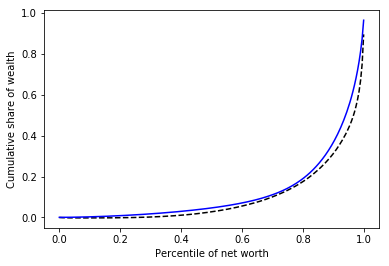

In [11]:
from HARK.cstwMPC.SetupParamsCSTW import SCF_wealth, SCF_weights
pctiles = np.linspace(0.001,0.999,200)
sim_wealth = np.concatenate([ThisType.aLvlNow for ThisType in MyTypes])
SCF_Lorenz_points = getLorenzShares(SCF_wealth,weights=SCF_weights,percentiles=pctiles)
sim_Lorenz_points = getLorenzShares(sim_wealth,percentiles=pctiles)
plt.plot(pctiles,SCF_Lorenz_points,'--k')
plt.plot(pctiles,sim_Lorenz_points,'-b')
plt.xlabel('Percentile of net worth')
plt.ylabel('Cumulative share of wealth')
plt.show()